In [1]:
import numpy as np

#visuals
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#Hugo code
import Utility
import PythonKEX 

In [212]:
print(PythonKEX.define_KEX_dataset.__doc__)
LM_paths, sino_paths, phantom_title, recon_paths = PythonKEX.define_KEX_dataset(isKanyl=False,TOF=True, recon_str="OP")

 return list mode paths, sinograms paths, phantom title (Cannula or Cylinder ), and paths to reconstructions 


In [213]:
#get data
histograms = []
for path in sino_paths:
    with open(path, "rb") as file: # safer than fromfile(path)
        histo_1D = np.fromfile(file,dtype=np.ushort)
        histograms.append(np.reshape(histo_1D, Utility.HISTOGRAM_SHAPE))
histograms = np.array(histograms)

In [214]:
# sanity check
print("histograms shape\n", histograms.shape)
print("dimension correspondence\n","histogram bin,", Utility.DIM_TITLES)

histograms shape
 (2, 14, 621, 168, 400)
dimension correspondence
 histogram bin, ['TOF bin ', 'michelogram bin ', 'transaxial angle bin ', 'radial offset bin ']


In [215]:
#see if sparse matrices would be useful
zeros = np.sum(histograms == 0)
total = np.prod(histograms.shape)
ratio = (total-zeros)/zeros
print(ratio)

0.008732509316163824


In [216]:
#calculate COM for each sinogram (tx, ro dimensions)
#this can probably be vectorized ( by changing CenterOfMassMultiplication)
#quite slow
axis = (1,3,4)
CenterOfMass = Utility.CenterOfMassMultiplication(histograms, axis=axis)
print("centers of mass shape\n", CenterOfMass.shape)

centers of mass shape
 (3, 2, 621)


In [217]:
#sanity check, with y-movement trough FOV center we expect change in ro between gate 0 and gate 1
print(CenterOfMass.shape)
print(CenterOfMass[:,0,50])
print(CenterOfMass[:,1,50])

(3, 2, 621)
[  2.46085071  83.42290935 223.30890977]
[  4.39009893  83.81259456 242.41373348]


In [218]:
#calculate how much to translate , to move gate 1 into gate 0 
#(we will perform sinogram registration with no interpolation)
reg_dtype=int
reference_id = 0
CenterOfMass = np.array(CenterOfMass, dtype=reg_dtype)

difference_com = CenterOfMass[:, reference_id,:] - CenterOfMass[:,reference_id ^ 1,:]
difference_com = difference_com[1:]
print("difference shape\n", difference_com.shape)
print("difference[:,0]=", difference_com[:,0])
print("dimensions\n", Utility.DIM_TITLES[2:])

difference shape
 (2, 621)
difference[:,0]= [  4 -13]
dimensions
 ['transaxial angle bin ', 'radial offset bin ']


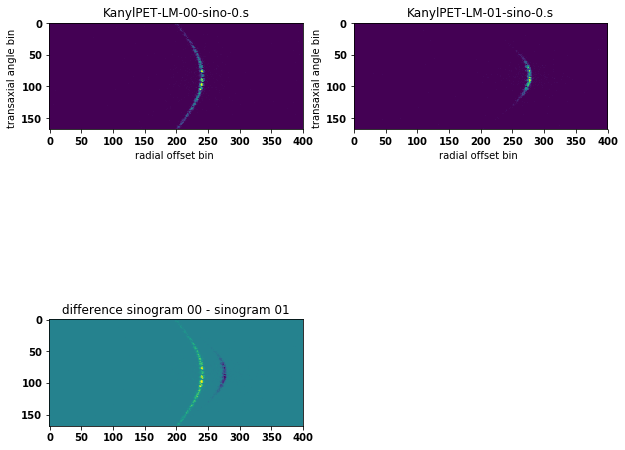

In [219]:
#visualize differences
mi = 50
tof = 0
plt.figure(figsize=(10,10))
for k in range(len(sino_paths)):
    plt.subplot(len(sino_paths), 2, k+1)
    plt.imshow(histograms[k,tof, mi])
    plt.xlabel(Utility.DIM_TITLES[3])
    plt.ylabel(Utility.DIM_TITLES[2])
    plt.title(sino_paths[k].split('/')[-1])
diff = np.array(histograms[0,tof,mi], dtype=int)-np.array(histograms[1,tof,mi], dtype=int)
plt.subplot(2,2,3)
plt.imshow(diff)
plt.title("difference sinogram 00 - sinogram 01")

plt.show()

In [220]:
#register sinograms
#bounds are the allowed start,end for the different dimension ranges

#prepare empty histogram for storage
corrected_histogram=np.zeros_like(histograms[reference_id])

to_bounds = np.zeros((2,difference_com.shape[0]),dtype=int)
from_bounds = np.zeros((2,difference_com.shape[0]), dtype=int)
#for low in [True,False]:  
#    if low:
#        if reg_dtype == int:
#            continue
#        else:
#            translations = np.floor(difference_com.shape[0],), dtype=int)
#            coefficients = 
#    else:
#        if reg_dtype == int:
#            translations = difference_com
#            coefficients = np.ones((Utility.NUMBER_OF_SINOGRAMS,))
#        else:
#            translations = np.floor(difference_com.shape[0],), dtype=int)
#            coefficients = 

bSymmetry = True

for k in range(0,Utility.NUMBER_OF_SINOGRAMS):
    #coms = np.array(Utility.CenterOfMassMultiplication(histograms[:,:,:,k,:], axis=(1,2,3)), dtype=int)
    #translation = coms[:2,0] - coms[:2, 1]
    translation = difference_com[:,k]
    #what moves inside image
    to_bounds[0] = np.maximum(translation,0)
    to_bounds[1] = corrected_histogram.shape[-len(translation):] + np.minimum(translation,0)
    from_bounds = to_bounds - translation

    corrected_histogram[:,k,
                        to_bounds[0,0]:to_bounds[1,0],
                        to_bounds[0,1]:to_bounds[1,1]] += histograms[reference_id ^ 1,
                                                                    :, k, 
                                                                    from_bounds[0,0]:from_bounds[1,0], 
                                                                    from_bounds[0,1]:from_bounds[1,1]]                                                             
    #what moves inside with angle symmetry [dimension]
    #use "clock arithmetic"
    #Line of response symmetry: LOR(ro, tx) = LOR(-ro, tx+pi)
    # two cases:
        #1)
        # to     |-r   y...y|
        # from   |x...x   +r|
        #        tx angle --> 
        #2)
        # to     |y...y   -r|
        # from   |+r   x...x|
        #        tx angle --> 

    #print("k", k)
    #print("translation", translation)
    #print("from_bounds\n", from_bounds)
    #print("to_bounds\n", to_bounds) 
    if bSymmetry:  
        if (translation[0] != 0):
            from_bounds[0,0] = from_bounds[1,0] % Utility.NUMBER_OF_VIEWS
            from_bounds[1,0] = from_bounds[0,0] + np.abs(translation[0])
            #from bounds for ro are the same

            to_bounds[0,0] = to_bounds[1,0] % Utility.NUMBER_OF_VIEWS
            to_bounds[1,0] = to_bounds[0,0] + np.abs(translation[0])
            # to_bounds for "negative ro" will be the flipped range
            #print("sym from\n", from_bounds)
            corrected_histogram[:,k,
                                to_bounds[0,0]:to_bounds[1,0],
                                to_bounds[0,1]:to_bounds[1,1]] = np.flip(histograms[reference_id ^ 1,
                                                                                       :,k,
                                                                                       from_bounds[0,0]:from_bounds[1,0],
                                                                                       from_bounds[0,1]:from_bounds[1,1]],
                                                                         axis=(2,))                                       

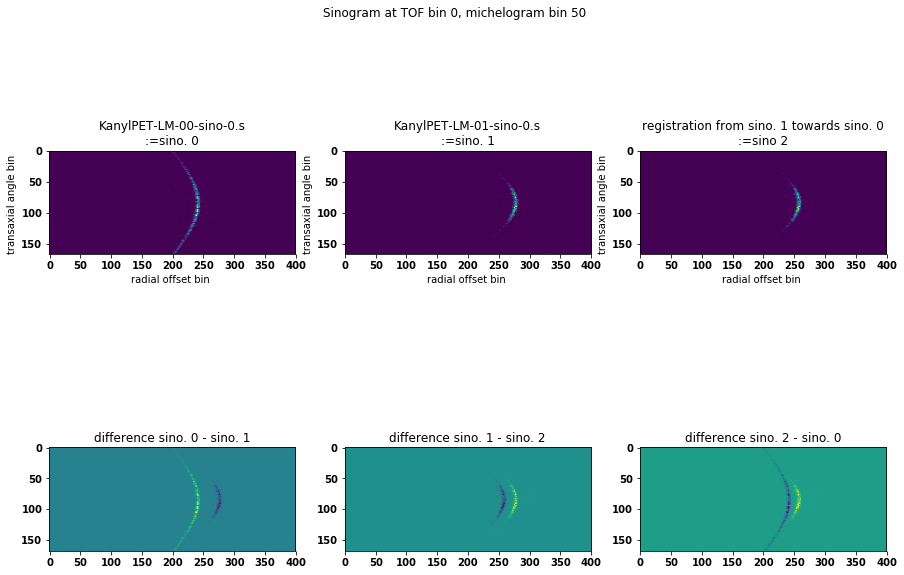

In [221]:
#visualize registration sinograms
mi = 50
tof = 0
plt.figure(figsize=(15,10))
position_str = "Sinogram at " + Utility.DIM_TITLES[0] + str(tof) +", " + Utility.DIM_TITLES[1] + str(mi) 
pixels = []
for k in range(len(sino_paths)):
    pixels.append(histograms[k,tof,mi])
pixels.append(corrected_histogram[tof,mi])

for k in range(len(pixels)):
    plt.subplot(2,len(pixels), k+1)
    plt.imshow(pixels[k])
    plt.xlabel(Utility.DIM_TITLES[3])
    plt.ylabel(Utility.DIM_TITLES[2])
    if k < len(sino_paths):
        plt.title(sino_paths[k].split('/')[-1] + "\n:=sino. " + str(k))
    else:
        plt.title("registration from sino. " + str(reference_id ^1) + " towards sino. " + str(reference_id) +"\n:=sino " + str(k))
    
    a = k
    b = (k+1) % len(pixels)
    diff = np.array(pixels[a],dtype=int) - np.array(pixels[b], dtype=int)
    plt.subplot(2,len(pixels), k+len(pixels)+1)
    plt.imshow(diff)
    plt.title("difference sino. " +str(a) + " - sino. " + str(b))
plt.suptitle( position_str)
plt.show() 

In [18]:
if bSymmetry:
    sym_mc_hist = corrected_histogram
else:
    mc_hist = corrected_histogram

In [19]:
print(np.sum(sym_mc_hist))
print(np.sum(mc_hist))

16706015
16689154


In [149]:
#save motion corrected sinograms
mc_str = "-MC"
if bSymmetry:
    mc_str = mc_str + "-Symmetry" 
    
mc_folder = r"MotionCorrections/"
sino_file = sino_paths[reference_id ^ 1].split('/')[-1]
folder_path = sino_paths[reference_id ^ 1].split(sino_file)[0] + mc_folder
histo_file = sino_file.split('.')[0] + mc_str + ".s"

mc_path = folder_path + histo_file
    #mc_paths.append(
    
#del mc_paths[0]

print("saving to\n", mc_path)


#for k, path in enumerate(mc_paths):
with open(mc_path, 'wb') as f:
    f.write(np.reshape(corrected_histogram, (np.prod(Utility.HISTOGRAM_SHAPE),)))

saving to
 C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-01/MotionCorrections/KanylPET-LM-01-sino-0-MC-Symmetry.s


0 0 1
1 1 2
2 2 0


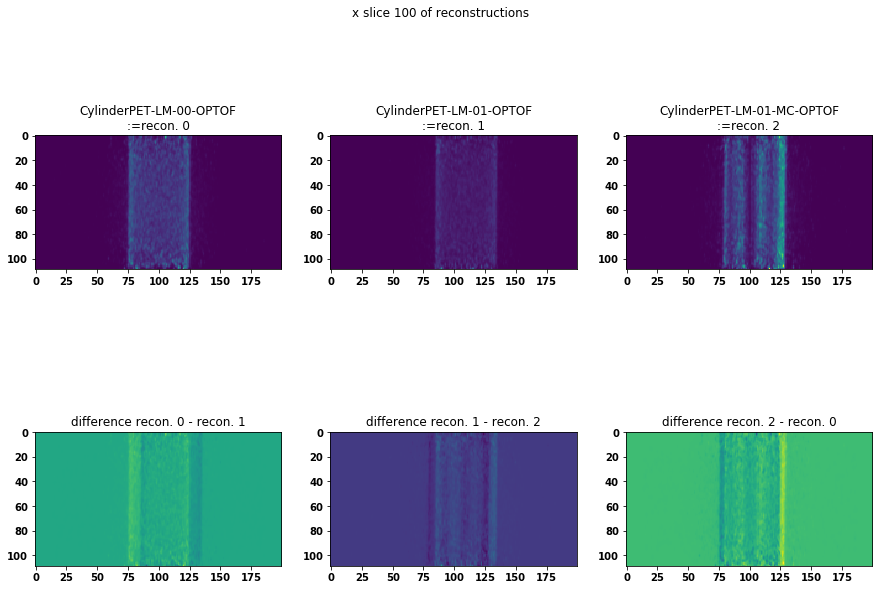

In [190]:
#look at reconstructions, at x
#similar to sinogram view
#ref, moving, corrected
#diff
#corr-diff-ref, corr-diff-mov
x = 100
paths = []
paths.append(sino_paths[reference_id].split('-sino-')[0] + "-OPTOF"  + "_000_000.v-DICOM")
paths.append(sino_paths[reference_id ^ 1].split('-sino-')[0] + "-OPTOF"  + "_000_000.v-DICOM")
paths.append(sino_paths[reference_id ^ 1].split('-sino-')[0] +  "-MC"+ "-OPTOF"  + "_000_000.v-DICOM")
pixels = []
for p in paths:
    phantom_dicom = Utility.load_scan(p)
    pixels.append(Utility.get_pixels_hu(phantom_dicom))
plt.figure(figsize=(15,10))
for k,p in enumerate(paths):
    plt.subplot(2,3,k+1)
    plt.imshow(pixels[k][:,:,x])
    plt.title(p.split('/')[-1].split('_')[0] + "\n:=recon. " + str(k))
    
    a = k
    b = (k+1) % len(paths)
    print(k, a, b)
    diff = np.array(pixels[a][:,:,x],dtype=int) - np.array(pixels[b][:,:,x],dtype=int)
    plt.subplot(2,3,k+4)
    plt.imshow(diff)
    plt.title("difference recon. " +str(a) + " - recon. " + str(b))
plt.suptitle("x slice " + str(x) + " of reconstructions")
plt.show() 

0 0 1
1 1 2
2 2 0


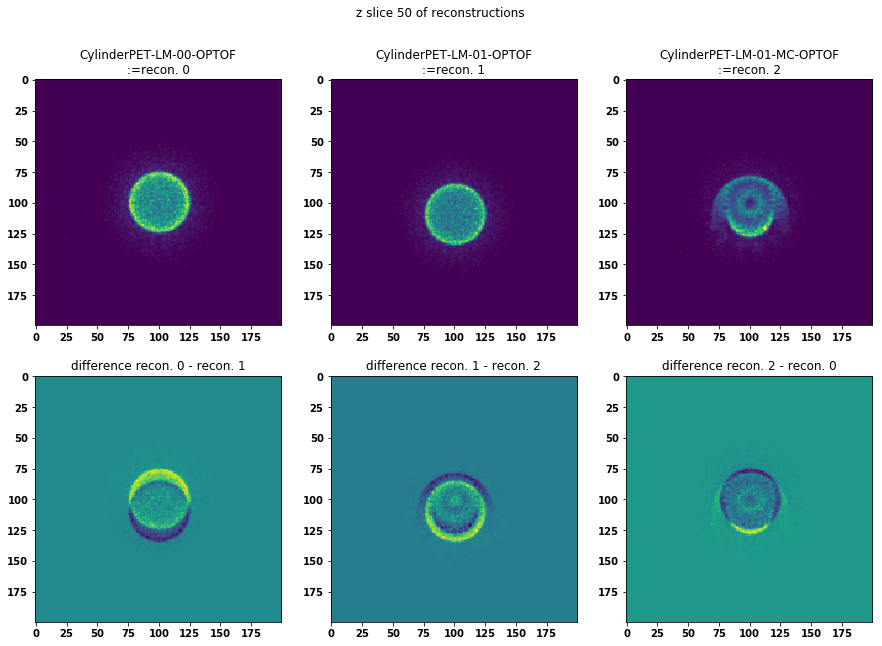

In [191]:
#look at reconstructions, at z
#similar to sinogram view
#ref, moving, corrected
#diff
#corr-diff-ref, corr-diff-mov
z = 50
paths = []
paths.append(sino_paths[reference_id].split('-sino-')[0] + "-OPTOF"  + "_000_000.v-DICOM")
paths.append(sino_paths[reference_id ^ 1].split('-sino-')[0] + "-OPTOF"  + "_000_000.v-DICOM")
paths.append(sino_paths[reference_id ^ 1].split('-sino-')[0] +  "-MC"+ "-OPTOF"  + "_000_000.v-DICOM")
pixels = []
for p in paths:
    phantom_dicom = Utility.load_scan(p)
    pixels.append(Utility.get_pixels_hu(phantom_dicom))
plt.figure(figsize=(15,10))
for k,p in enumerate(paths):
    plt.subplot(2,3,k+1)
    plt.imshow(pixels[k][z,:,:])
    plt.title(p.split('/')[-1].split('_')[0] + "\n:=recon. " + str(k))
    
    a = k
    b = (k+1) % len(paths)
    print(k, a, b)
    diff = np.array(pixels[a][z,:,:],dtype=int) - np.array(pixels[b][z,:,:],dtype=int)
    plt.subplot(2,3,k+4)
    plt.imshow(diff[:,:])
    plt.title("difference recon. " +str(a) + " - recon. " + str(b))
plt.suptitle("z slice " + str(z) + " of reconstructions")
plt.show() 

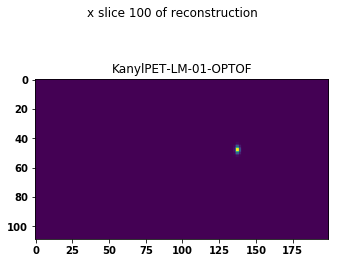

In [171]:
#look at original corrected reconstruction
orig_recon_path = 
x= 100
#print(orig_recon_path)
plt.figure(figsize=(10,10))
orig_dicom= 
orig_pixels = Utility.get_pixels_hu(orig_dicom)
plt.subplot(3,1,1)
plt.imshow(orig_pixels[:,:,x])
plt.title(orig_recon_path.split('/')[-1].split('_')[0])
plt.suptitle("x slice " + str(x) + " of reconstruction")
plt.show()

C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-01/KanylPET-LM-01-MC-OPTOF_000_000.v-DICOM


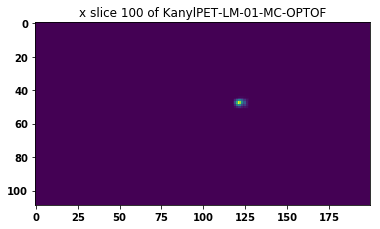

In [164]:
#look at motion corrected reconstruction
mc_recon_path = sino_paths[reference_id ^ 1].split('-sino-')[0] +  "-MC"+ "-OPTOF"  + "_000_000.v-DICOM"
x = 100
print(mc_recon_path)
mc_dicom= Utility.load_scan(mc_recon_path)
mc_pixels = Utility.get_pixels_hu(mc_dicom)
plt.imshow(mc_pixels[50,:,:])

plt.title("x slice " + str(x) + " of " + mc_recon_path.split('/')[-1].split('_')[0])
plt.show()

C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-01/KanylPET-LM-01-MC-Symmetry-OPTOF_000_000.v-DICOM


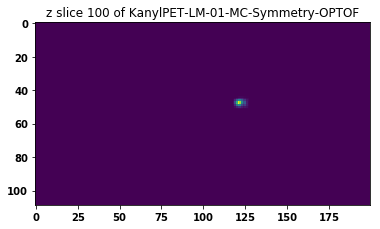

In [174]:
#look at Symmetry option corrected reconstruction
mc_recon_path = sino_paths[reference_id ^ 1].split('-sino-')[0] + "-MC-Symmetry"+ "-OPTOF"  + "_000_000.v-DICOM"
x = 100
print(mc_recon_path)
mc_dicom= Utility.load_scan(mc_recon_path)
mc_pixels2 = Utility.get_pixels_hu(mc_dicom)
plt.imshow(mc_pixels2[:,:,x])
plt.title("z slice " + str(x) + " of " + mc_recon_path.split('/')[-1].split('_')[0])
plt.show()

In [46]:
diff = mc_pixels2 - mc_pixels

In [47]:
print(np.sum(diff))

4013941


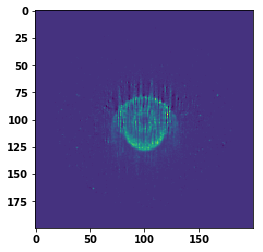

In [49]:
plt.imshow(diff[50,:,:])
plt.show()

In [ ]:
mc_img_com = Utility.CenterOfMassMultiplication(mc_pixels, axis=(0,1,2))
orig_img_com = Utility.CenterOfMassMultiplication(orig_pixels, axis = (0,1,2))

In [ ]:
print(mc_img_com)
print(orig_img_com)

In [ ]:
diff = orig_pixels - mc_pixels 

In [ ]:
print(np.sum(diff))

In [ ]:

plt.imshow(diff[:,:,100])
plt.show()

In [ ]:
A = np.arange(0,6,1)
A =np.reshape(A, newshape=(2,3))
print("A\n",A)
B = np.zeros(A.shape,dtype=int)
print("B\n", B)
grid = np.meshgrid((0,1), (0,1,2))
print("grids\n", grid[0], "\n\n", grid[1])
grid2 = np.zeros((2,) + grid[0].shape,dtype=int)
grid2[0] = grid[0] + [0,0]
grid2[1] = grid[1] + [[1],[1],[1]]
inside = grid2[1] < 3
print("grid2\n", grid2[0], "\n\n", grid2[1])
g2x = grid2[0][inside]
g2y = grid2[1][inside]
gx = grid[0][inside]
gy = grid[1][inside]
print("g2x", g2x, "g2y", g2y,"gx", gx,"gy",gy)

B[g2x,g2y] = A[gx,gy]
print("A moved to inside B\n", B)

In [ ]:
print(np.indices((1,2,3)))
    
    
    

In [ ]:
#translate ro and tx
grid2 = np.array(grid,dtype=int)
grid2ro = grid2[0][:,0,0,0]
grid2tx



In [ ]:
#look what falls inside
#there is probably a more efficient way of doing this
inside = grid2[0] > -1
inside = inside & grid2[0] < corrected_histogram.shape[0]
inside = inside & grid2[1] > -1
inside = inside & grid2[1] < corrected_histogram.shape[1]

In [ ]:
tx_dim = Utility.HISTOGRAM_SHAPE.index(Utility.NUMBER_OF_VIEWS)
#destination indiex bounds, low:high
to_bounds = np.zeros(difference_com.shape + (2,), dtype=int)
from_bounds = np.zeros(difference_com.shape + (2,), dtype=int)



#translate within matrix shape
for t in range(0,translation.shape[0]):
    
    positive_diff = difference_com[t] > 0
    non_positive = positive_diff ^ True
    #lower and upper bounds
    #positive translations
    to_bounds[t,:,:,0][positive_diff] = difference_com[t][positive_diff]
    to_bounds[t,:,:,1][positive_diff] = Utility.HISTOGRAM_SHAPE[t]
    from_bounds[t,:,:,0][positive_diff] = 0
    from_bounds[t,:,:,1][positive_diff] = Utility.HISTOGRAM_SHAPE[t] - difference_com[t][positive_diff]
    
    #non-positive
    to_bounds[t,:,:,0][non_positive] = 0
    to_bounds[t,:,:,1][non_positive] = Utility.HISTOGRAM_SHAPE[t] + difference_com[t][non_positive]
    from_bounds[t,:,:,0][non_positive]  = difference_com[t][non_positive]
    from_bounds[t,:,:,1][non_positive]  = Utility.HISTOGRAM_SHAPE[t] - difference_com[t][non_positive]
    
print("pos", positive_translation)
print("np", non_positive)
print("pt", pt_index[0])
print("nt", nt_index)

    #to_bounds[t,pt_index,0] = translation[t,pt_index]
    #to_bounds[t,pt_index,1] = Utility.HISTOGRAM_SHAPE[t]

    #to_bounds[t,nt_index,0] = 0
    #to_bounds[t,nt_index,1] = Utility.HISTOGRAM_SHAPE[t] + translation[t, nt_index]

    #from_bounds[t] = to_bounds[t] - translation[t]
#if (k==0):
    #print("translation\n",translation)
    #print("to_bounds\n",to_bounds)
    #print("from_bounds\n",from_bounds)

corrected_histogram[] = histograms_3D[i,
                                        from_bounds[0,0]:from_bounds[0,1],
                                       from_bounds[1,0]:from_bounds[1,1],
                                         j]

#also include some omitted entries via angle symmetry
# use histogram(ro, tx+-pi) = histogram(-ro, tx)
# use "clock arithmetic"
#if (translations[tx_dim] > 0):
#    to_bounds[tx_dim] = [0, translation[tx_dim]]
#    from_bounds[tx_dim] = [from_bounds[0], Utility.HISTOGRAM_SHAPE[tx_dim]]
#else:
#    to_bounds[tx_dim] = [0, translation[tx_dim]] 

In [ ]:
A = np.array([1,2,3])
B = A > 2
print(B)
print(B ^ True)

In [ ]:
#prepare empty 3D histogram
#concatenate tuple for shape
corrected_histograms = np.zeros((len(sino_paths)-1,)+histograms_3D.shape[1:], dtype=np.ushort )

In [ ]:
for i in range(0, len(sino_paths)-1):
    for k in range(0, Utility.NUMBER_OF_SINOGRAMS):
        
        translation = difference_com[i,j]
        tx_dim = Utility.HISTOGRAM_SHAPE.index(Utility.NUMBER_OF_VIEWS)
        #destination indiex bounds, low:high
        to_bounds = np.zeros((len(translation),2), dtype=int)
        from_bounds = np.zeros((len(translation),2), dtype=int)
        #inside matrix
        for t in range(0,2):
            if translation[t] > 0:
                to_bounds[t] = [translation[t], Utility.HISTOGRAM_SHAPE[t]]
            else: 
                to_bounds[t] = [0, Utility.HISTOGRAM_SHAPE[t] + translation[t]]
            from_bounds[t] = to_bounds[t] - translation[t]
        if (k==0):
            print("translation\n",translation)
            print("to_bounds\n",to_bounds)
            print("from_bounds\n",from_bounds)
        
        corrected_histograms[i,
                             to_bounds[0,0]:to_bounds[0,1], 
                             to_bounds[1,0]:to_bounds[1,1],
                             j] = histograms_3D[i,
                                                from_bounds[0,0]:from_bounds[0,1],
                                                from_bounds[1,0]:from_bounds[1,1],
                                                 j]
        
        #also include some omitted entries via angle symmetry
        # use histogram(ro, tx+-pi) = histogram(-ro, tx)
        # use "clock arithmetic"
        #if (translations[tx_dim] > 0):
        #    to_bounds[tx_dim] = [0, translation[tx_dim]]
        #    from_bounds[tx_dim] = [from_bounds[0], Utility.HISTOGRAM_SHAPE[tx_dim]]
        #else:
        #    to_bounds[tx_dim] = [0, translation[tx_dim]] 
        

In [ ]:
#remove TOF dimension
histograms_3D = np.sum(histograms, axis = 1+Utility.HISTOGRAM_SHAPE.index(len(Utility.TOF_OFFSET_MAP)+1))
print(histograms_3D.shape)

In [ ]:
#register the second gate to the first gate in sinogram coordinates
discrete_com = np.array(CenterOfMass, dtype=int)
diff_com = discrete_com[0] - discrete_com[1]
print(diff_com)
#first radially
#then by angle

In [ ]:
#convert to offset histogram
len_axial_offset_bins = Utility.SEGMENT_TABLE[0]
len_segment_bins = len(Utility.SEGMENT_TABLE)
print(Utility.listmodePathToHistogram.__name__, " documentation \n", Utility.listmodePathToHistogram.__doc__)
offset_histogram = np.zeros((Utility.NUMBER_OF_PROJECTIONS, 
                            Utility.NUMBER_OF_VIEWS,
                            Utility.NUMBER_OF_SINOGRAMS,
                            1+len(Utility.TOF_OFFSET_MAP)))


In [ ]:
recons = []
for path in recon_paths:
    recons.append(Utility.get_pixels_hu(Utility.load_scan(path)))

In [ ]:
# look at images
axial_slice = 50
plt.figure(figsize=(20,10))
for k,rec in enumerate(recons, start=0):
    plt.subplot(1, len(recons), k+1)
    plt.imshow(rec[axial_slice])
    plt.title("axial slice " + str(axial_slice) + " of " + recon_paths[k].split('/')[6].split('_')[0])
plt.show()